# 초급 머신러닝 미션: "스포티파이 음악 클러스터링"

## 🎯 목표
스포티파이의 음악 인기도(popularity)와 음악 특성 데이터를 분석하여, "음악 패턴에 따른 군집화"를 수행합니다.

---

## 📂 사용 데이터셋
**Kaggle - Spotify Tracks DB Data**  
👉 https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db

> 이 데이터셋은 수많은 트랙들의 특성과 사용자의 스트리밍 기록을 포함합니다.

---

## 📌 실습 과제 구성

### Part 1. 데이터 전처리 및 탐색
- 불필요한 컬럼 제거 및 결측치 처리
- 수치형/범주형 데이터 분리 및 인코딩
- 주요 feature들의 분포 시각화


### Part 2. 음악 클러스터링(Clustering)
- 목표: 음악 패턴에 따라 그룹화
- 알고리즘
  - `KMeans`
  - `DBSCAN` 
- 시각화: PCA 또는 t-SNE를 활용한 2D 클러스터링 결과


### Part 3. 분석 및 해석
- 군집별 주요 특징 비교 (`mean`, `mode` 등으로 요약)
- 이탈률 높은 클러스터 존재 여부 확인




데이터 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signatur

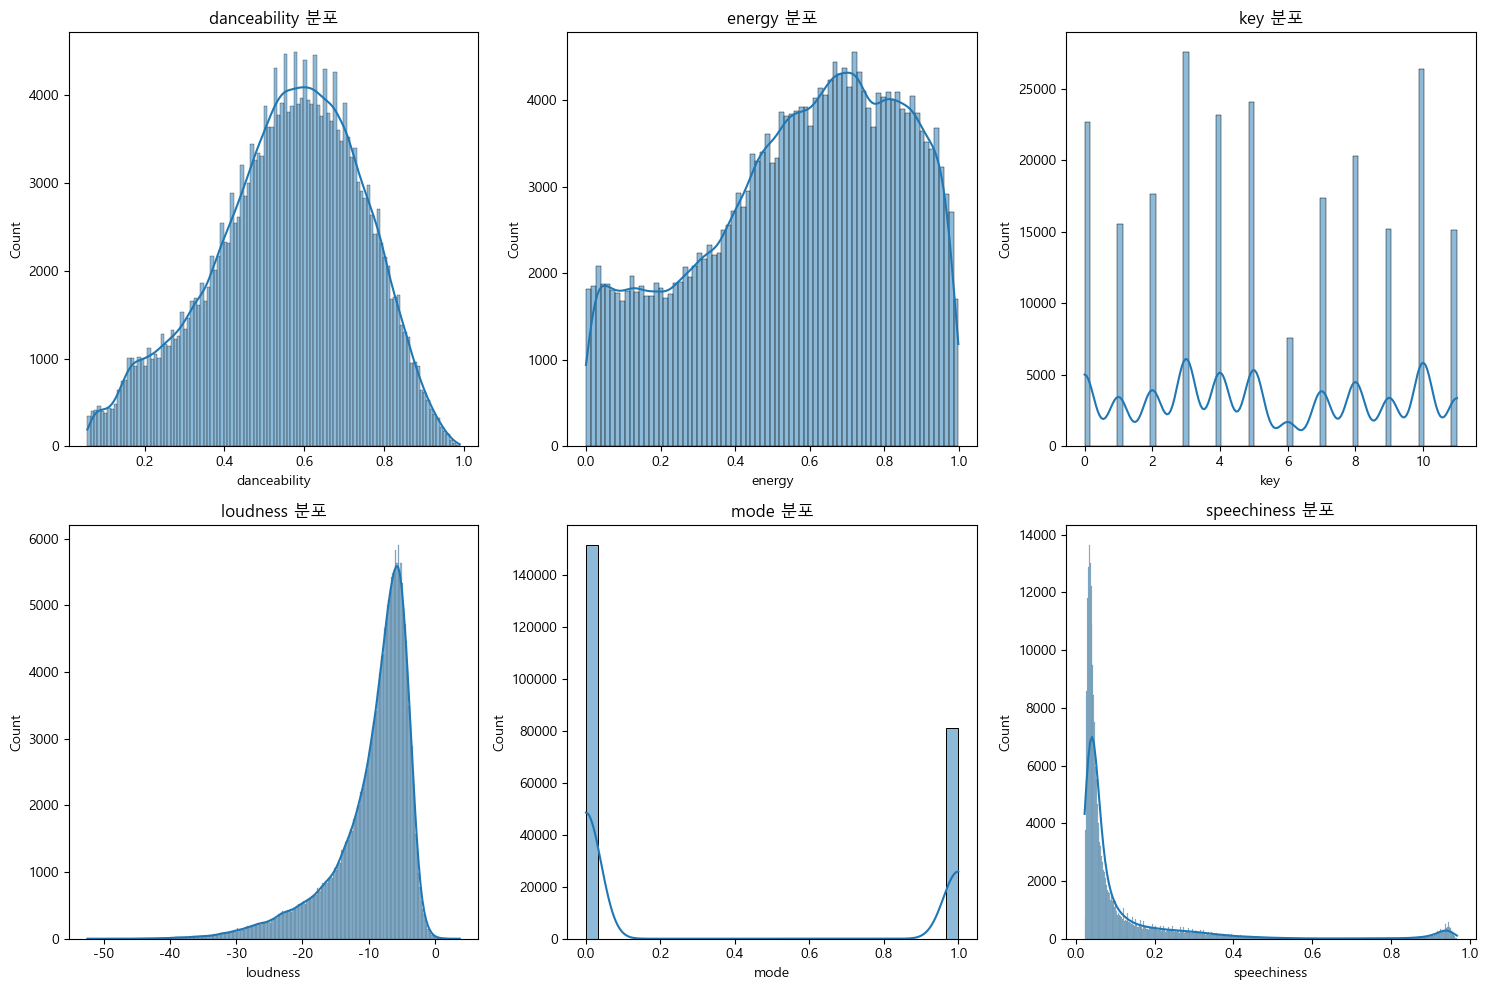

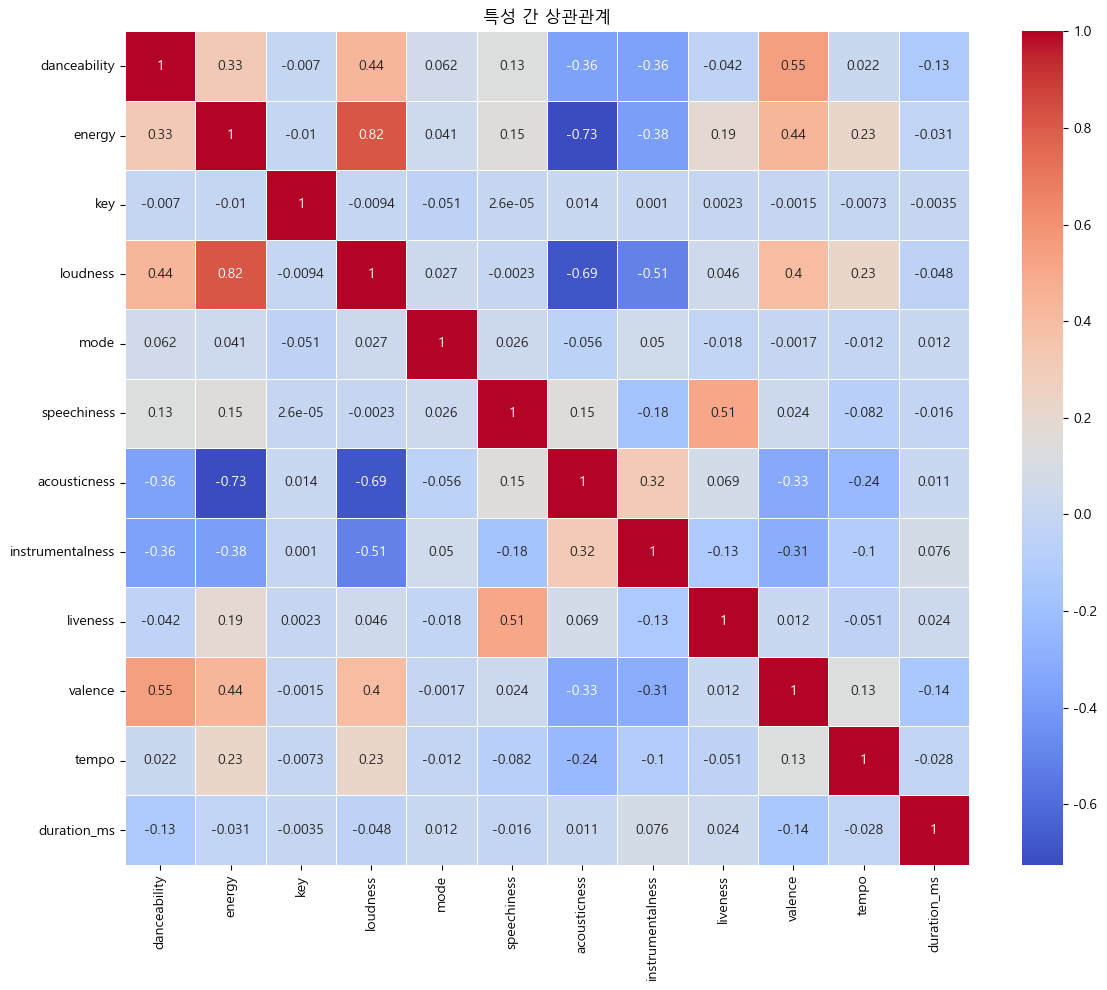

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드
df = pd.read_csv('SpotifyFeatures.csv')

# 1: 데이터 전처리 및 탐색
# 기본 데이터 정보 확인
print("데이터 정보")
print(df.info())

# 불필요한 컬럼 제거
columns_to_drop = ['track_href', 'type', 'uri']
df = df.drop(columns=columns_to_drop, errors='ignore')

# 결측치 처리
print("\n결측치 정보")
print(df.isnull().sum())
df = df.dropna()

# 범주형 데이터 인코딩
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

# 수치형 특성 선택
numeric_features = [
    'danceability', 'energy', 'key', 'loudness', 'mode', 
    'speechiness', 'acousticness', 'instrumentalness', 
    'liveness', 'valence', 'tempo', 'duration_ms'
]

# 특성 분포 시각화
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features[:6], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} 분포')
plt.tight_layout()
plt.show()

# 특성 간 상관관계 분석
plt.figure(figsize=(12, 10))
correlation_matrix = df[numeric_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('특성 간 상관관계')
plt.tight_layout()
plt.show()

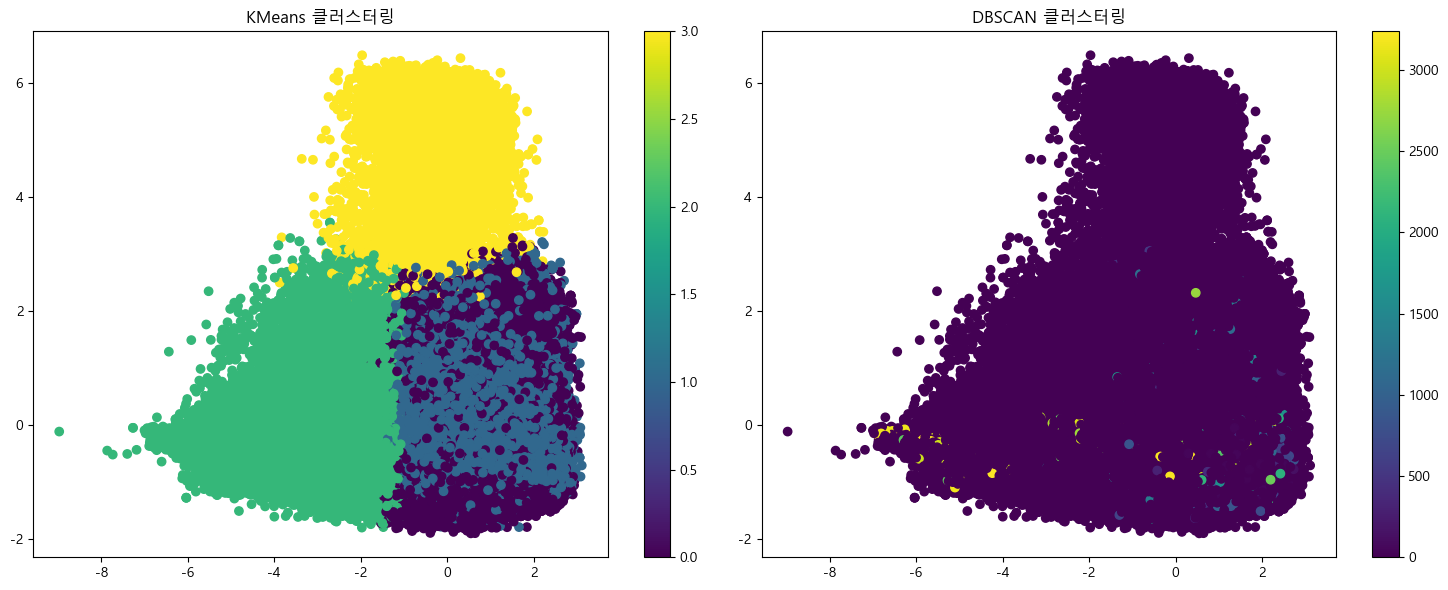

KMeans 클러스터 수: 4
DBSCAN 클러스터 수: 3241

KMeans 클러스터 평균 특성:
     danceability    energy       key   loudness      mode  speechiness  \
0.0      0.509619  0.732219  5.352958  -6.427423  0.272593     0.087893   
1.0      0.684719  0.612582  5.304923  -7.750210  0.427711     0.103387   
2.0      0.363061  0.224301  5.395026 -17.458189  0.311897     0.050637   
3.0      0.562469  0.660336  5.414744 -11.992925  0.315311     0.867794   

     acousticness  instrumentalness  liveness   valence       tempo  \
0.0      0.148695          0.090184  0.235214  0.439914  137.736608   
1.0      0.274561          0.060433  0.169673  0.590497  109.924179   
2.0      0.803048          0.441115  0.168341  0.217781  106.406469   
3.0      0.787072          0.001365  0.724973  0.415489   98.239335   

       duration_ms  
0.0  242739.751261  
1.0  222275.040933  
2.0  247008.170225  
3.0  244349.190458  

DBSCAN 클러스터 평균 특성:
         danceability    energy       key   loudness      mode  speechiness  \
-1.0   

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 스케일링
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_features])

# KMeans 클러스터링
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

# DBSCAN 클러스터링
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_features)

# PCA 차원 축소
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# 시각화
plt.figure(figsize=(15, 6))

# KMeans 시각화
plt.subplot(121)
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                      c=kmeans_labels, cmap='viridis')
plt.title('KMeans 클러스터링')
plt.colorbar(scatter)

# DBSCAN 시각화
plt.subplot(122)
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], 
                      c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN 클러스터링')
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

# 클러스터링 결과 요약
print("KMeans 클러스터 수:", len(np.unique(kmeans_labels)))
print("DBSCAN 클러스터 수:", len(np.unique(dbscan_labels)))

# 클러스터별 특성 분석
kmeans_summary = df.groupby(pd.Series(kmeans_labels))[numeric_features].mean()
print("\nKMeans 클러스터 평균 특성:")
print(kmeans_summary)

dbscan_summary = df.groupby(pd.Series(dbscan_labels))[numeric_features].mean()
print("\nDBSCAN 클러스터 평균 특성:")
print(dbscan_summary)


KMeans 클러스터별 평균 특성:
                danceability    energy       key   loudness      mode  \
KMeans_Cluster                                                          
0                   0.504007  0.745044  5.345559  -6.157405  0.261147   
1                   0.693257  0.614076  5.301618  -7.721783  0.435987   
2                   0.354758  0.201661  5.413522 -17.922699  0.312848   
3                   0.562345  0.660965  5.412006 -12.009102  0.315995   

                speechiness  acousticness  instrumentalness  liveness  \
KMeans_Cluster                                                          
0                  0.088087      0.128726          0.081979  0.241022   
1                  0.103209      0.273319          0.057981  0.167172   
2                  0.049657      0.835436          0.458495  0.163764   
3                  0.872797      0.789529          0.001256  0.728193   

                 valence       tempo    duration_ms  
KMeans_Cluster                                 

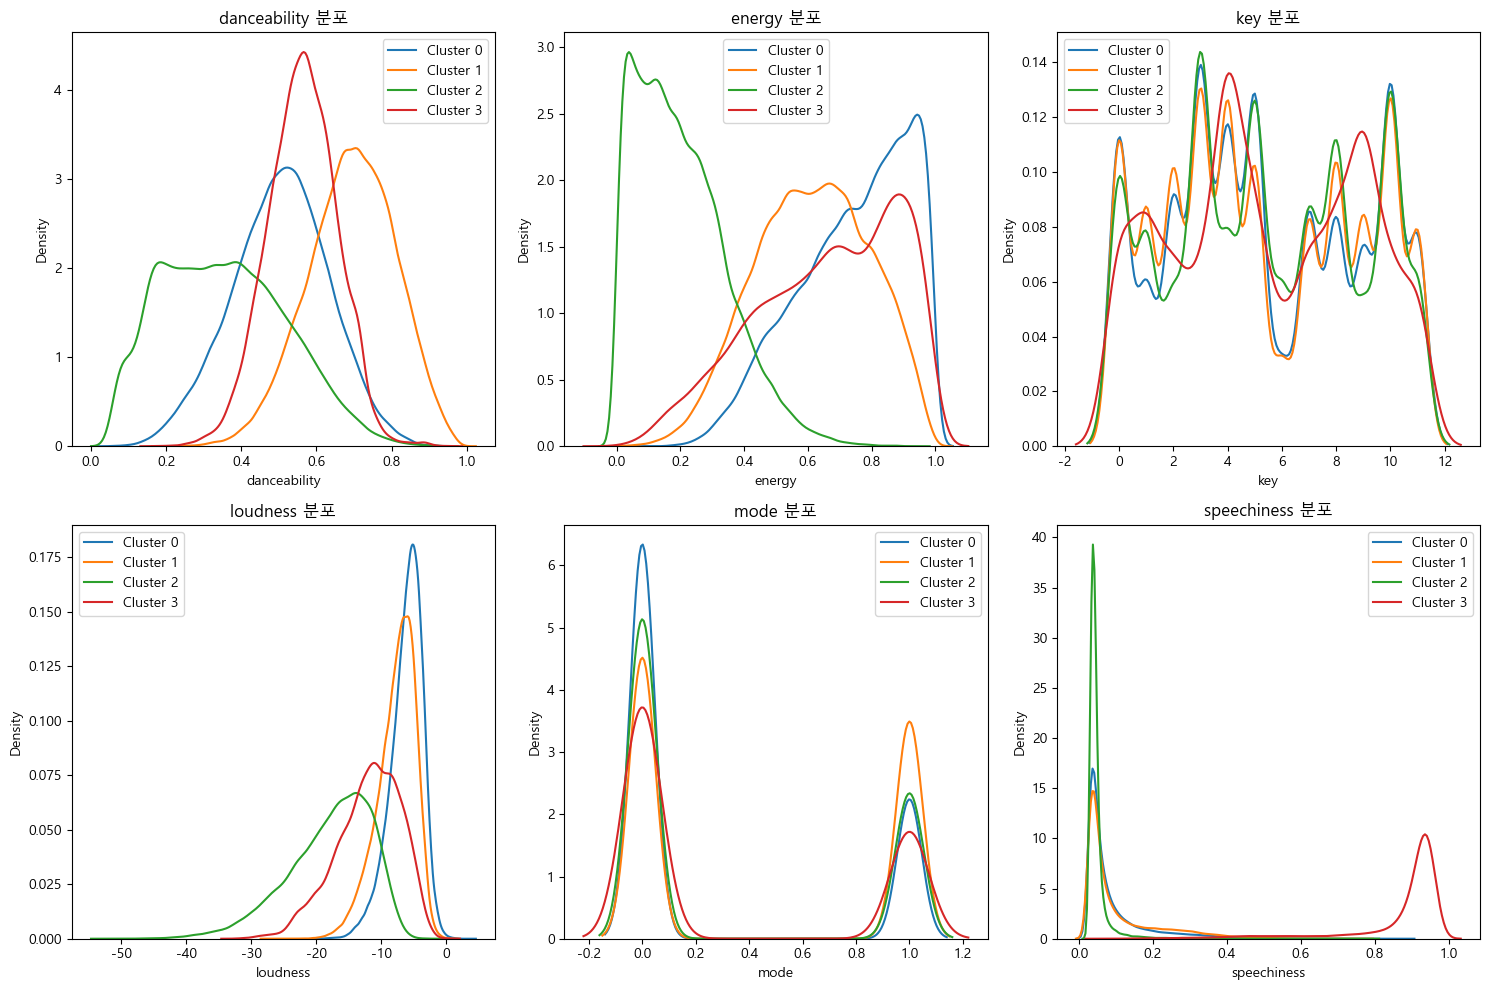


DBSCAN 클러스터별 평균 특성:
                danceability    energy       key   loudness      mode  \
DBSCAN_Cluster                                                          
-1                  0.550142  0.556837  5.345045  -9.948253  0.360168   
 0                  0.724000  0.689000  5.000000  -5.922000  1.000000   
 1                  0.510000  0.331000  2.000000 -13.073000  1.000000   
 2                  0.670000  0.649000  3.000000  -7.426000  1.000000   
 3                  0.377000  0.255000  7.000000 -11.165000  1.000000   
...                      ...       ...       ...        ...       ...   
 3235               0.804500  0.515000  2.250000  -6.975250  0.000000   
 3236               0.459600  0.859400  0.000000  -5.231600  1.000000   
 3237               0.734800  0.427200  9.600000 -11.866800  0.000000   
 3238               0.607000  0.230600  2.000000  -9.562800  0.000000   
 3239               0.736000  0.778200  3.000000  -5.675000  1.000000   

                speechiness  

C:\Users\user\AppData\Local\Temp\ipykernel_228904\2704287786.py:68: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['DBSCAN_Cluster'] == cluster][feature], label=f'Cluster {cluster}')
C:\Users\user\AppData\Local\Temp\ipykernel_228904\2704287786.py:68: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['DBSCAN_Cluster'] == cluster][feature], label=f'Cluster {cluster}')
C:\Users\user\AppData\Local\Temp\ipykernel_228904\2704287786.py:68: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df[df['DBSCAN_Cluster'] == cluster][feature], label=f'Cluster {cluster}')
C:\Users\user\AppData\Local\Temp\ipykernel_228904\2704287786.py:68: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


In [ ]:
# KMeans 클러스터링 결과 분석
df['KMeans_Cluster'] = kmeans_labels

# 클러스터별 특성 요약 (KMeans)
kmeans_cluster_summary = df.groupby('KMeans_Cluster')[numeric_features].mean()
print("\nKMeans 클러스터별 평균 특성:")
print(kmeans_cluster_summary)

# KMeans 클러스터별 주요 특징 분석
for cluster in range(n_clusters):
    print(f"\nKMeans 클러스터 {cluster} 특징:")
    cluster_data = kmeans_cluster_summary.loc[cluster]
    
    # 가장 높은 값을 가진 특성 3개 출력
    top_features = cluster_data.nlargest(3)
    print("주요 특성:")
    for feature, value in top_features.items():
        print(f"{feature}: {value:.2f}")

# KMeans 클러스터 크기
kmeans_cluster_sizes = df['KMeans_Cluster'].value_counts()
print("\nKMeans 클러스터 크기:")
print(kmeans_cluster_sizes)

# KMeans 클러스터별 분포 시각화
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features[:6], 1):
    plt.subplot(2, 3, i)
    for cluster in range(n_clusters):
        sns.kdeplot(df[df['KMeans_Cluster'] == cluster][feature], label=f'Cluster {cluster}')
    plt.title(f'{feature} 분포')
    plt.legend()
plt.tight_layout()
plt.show()

# DBSCAN 클러스터링 결과 분석
df['DBSCAN_Cluster'] = dbscan_labels

# DBSCAN 클러스터별 특성 요약
dbscan_cluster_summary = df.groupby('DBSCAN_Cluster')[numeric_features].mean()
print("\nDBSCAN 클러스터별 평균 특성:")
print(dbscan_cluster_summary)

# DBSCAN 클러스터별 주요 특징 분석
dbscan_clusters = np.unique(dbscan_labels)
for cluster in dbscan_clusters:
    if cluster != -1:  # 노이즈 포인트 제외
        print(f"\nDBSCAN 클러스터 {cluster} 특징:")
        cluster_data = dbscan_cluster_summary.loc[cluster]
        
        # 가장 높은 값을 가진 특성 3개 출력
        top_features = cluster_data.nlargest(3)
        print("주요 특성:")
        for feature, value in top_features.items():
            print(f"{feature}: {value:.2f}")

# DBSCAN 클러스터 크기
dbscan_cluster_sizes = df['DBSCAN_Cluster'].value_counts()
print("\nDBSCAN 클러스터 크기:")
print(dbscan_cluster_sizes)

# DBSCAN 클러스터별 분포 시각화
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features[:6], 1):
    plt.subplot(2, 3, i)
    for cluster in dbscan_clusters:
        if cluster != -1:
            sns.kdeplot(df[df['DBSCAN_Cluster'] == cluster][feature], label=f'Cluster {cluster}')
    plt.title(f'{feature} 분포')
    plt.legend()
plt.tight_layout()
plt.show()